# Simulation study
### Setting:
- $\beta = 0.006$
- $10000$ miners
- Measurement error correction
- weakly infrmative prior with cox, i.e. $\beta \sim N(0,1.28)$

Written to `b6-10`

In [1]:
# general libraries
import os
import numpy as np
import scipy.stats as stats
import warnings
import multiprocessing
import time
import matplotlib.pyplot as plt
import seaborn as sns


# sampling code
import sys
sys.path.append('..')
import wismut.basics as basics
from wismut.MCMC import MCMC
import wismut.analyze_chains as ac
path = os.getcwd() + "/"

### Define prior parameters

In [2]:
def generate_prior_parameters():
    prior_parameters = {'beta': {'dist': "normal", 'mean': 0, 'sd': 1.28},
                        'lambda1': {'dist': "gamma",'shape': 600,
                                    'scale': 1 / 10000000,
                                    'min': 0, 'max': 200
                                    },
                        'lambda2': {'dist': "gamma", 'shape': 12000,
                                    'scale': 1 / 1000000,
                                    'min': 0, 'max': 200
                                    },
                        'lambda3': {'dist': "gamma", 'shape': 46000,
                                    'scale': 1 / 1000000,
                                    'min': 0, 'max': 200
                                    },
                        'lambda4': {'dist': "gamma", 'shape': 1000,
                                    'scale': 1 / 100000,
                                    'min': 0, 'max': 200
                                    },
                        'C_Rn_mu': {'dist': "normal", 'mean': 6, 'sd': 5},
                        'C_Rn_sigma': {'dist': "normal", 'mean': 8, 'sd': 0.5},
                        'C_Exp_mu': {'dist': "normal", 'mean': 1.78, 'sd': 3},
                        'C_Exp_sigma': {'dist': "normal", 'mean': 0.79, 'sd': 2},
                        'C_RPD_mu': {'dist': "normal", 'mean': 0.15, 'sd': 0.03},
                        'C_RPD_sigma': {'dist': "normal", 'mean': 0.2, 'sd': 0.03},
                        'zeta_alpha': {'dist': "normal", 'mean': 3, 'sd': 2},
                        'zeta_beta': {'dist': "normal", 'mean': 3, 'sd': 2},
                        'gamma_alpha': {'dist': "normal", 'mean': 3, 'sd': 2},
                        'gamma_beta': {'dist': "normal", 'mean': 3, 'sd': 2},
                        'phi_alpha': {'dist': "normal", 'mean': 3, 'sd': 2},
                        'phi_beta': {'dist': "normal", 'mean': 3, 'sd': 2},
                        'omega_alpha': {'dist': "normal", 'mean': 3, 'sd': 2},
                        'omega_beta': {'dist': "normal", 'mean': 3, 'sd': 2},
                        }
    return prior_parameters



### Deinfe Proposal sds for MCMC

In [3]:
def generate_proposal_sds(disease_model='cox'):
    proposal_sd = {
            'beta': 0.011 if disease_model == 'cox' else 0.00011*10,
            'lambda1': 0.000211,
            'lambda2': 0.000611,
            'lambda3': 0.000611,
            'lambda4': 0.000211,
            'C_Rn_old_mu': 0.2,
            'C_Rn_old_sigma': 0.2,
            'C_Rn_ref_mu': 0.2,
            'C_Rn_ref_sigma': 0.2,
            'C_Rn_mu': 0.2,
            'C_Rn_sigma': 0.2,
            'C_RPD_mu': 0.2,
            'C_RPD_sigma': 0.2,
            'C_Exp_mu': 0.4,
            'C_Exp_sigma': 0.5,
            'zeta_alpha': 0.5,
            'zeta_beta': 0.5,
            'gamma_alpha': 0.5,
            'gamma_beta': 0.5,
            'phi_alpha': 0.5,
            'phi_beta': 0.5,
            'omega_alpha': 0.5,
            'omega_beta': 0.5,
            }
    return proposal_sd

### Define Start values of Markov chains

In [4]:
def generate_start_values(seed, chain, disease_model="cox_like", me_correction=True):
    np.random.seed(seed)
    rnd = lambda: stats.uniform(loc=0.9, scale=0.2).rvs(1)[0]
    
    beta_true = 0.6 if disease_model == "cox_like" else 1.0
    l1 = 0.00006
    l2 = 0.00120
    l3 = 0.00460
    l4 = 0.01000

    start_values = {chain: {'beta': beta_true * rnd(),
                               'lambda1': l1 * rnd(),
                               'lambda2': l2 * rnd(),
                               'lambda3': l3 * rnd(),
                               'lambda4': l4 * rnd(),
                               # values for truncnorm
                               'prior_parameters': {
                                                    'M2': {'C_Rn': {'mu': 6 * rnd(),
                                                                    'sigma': 8 * rnd()
                                                                    },
                                                           },
                                                    'M2_Expert': {'C_Exp': {'mu': 1.78 * rnd(),
                                                                            'sigma': 0.79 * rnd()
                                                                            },
                                                                  },
                                                    'M3': {'C_RPD': {'mu': 0.15 * rnd(),
                                                                    'sigma': 0.2 * rnd()
                                                                     },
                                                           'zeta': {'alpha': 3 * rnd(),
                                                                    'beta': 3 * rnd()
                                                                    }
                                                           },
                                                    'equilibrium': {'gamma': {'alpha': 3 * rnd(),
                                                                              'beta': 3 * rnd()
                                                                              }
                                                                    },
                                                    'activity': {'phi': {'alpha': 3 * rnd(),
                                                                         'beta': 3 * rnd()
                                                                         }
                                                                 },
                                                    'working_time': {'omega': {'alpha': 3 * rnd(),
                                                                               'beta': 3 * rnd()
                                                                                }
                                                                     },
                                                    }
                               }
                    }
    if not me_correction:
        del start_values[chain]['prior_parameters']

    return start_values


### Define uncertainty characteristics

In [5]:
###########################
# M1a M2 M2_Expert M3 M4
###########################
uncertainty_characteristics = {
        'M1a': {'C_Rn_old': {'classical_error': {'sd': 6.56, 'structure': 'additive', 'proposal_sd': 1.5},
                             # 'classical_error': {'sd': 0, 'structure': 'additive', 'proposal_sd': 0.1},
                             'Berkson_error': {'sd': 0},
                             'exposure_model_distribution': 'norm',
                             'exposure_model_parameters': {'mu': 22.5, 'sigma': 4},  # 4 is arbitrary
                             'exposure_model_truncation': {'lower': 1e-10},
                             'mapping_identifier_classical': ['cluster_C_Rn_old'],  # empty on purpose
                             'name_obs_values': 'C_Rn_old'
                             # 'name_obs_values': 'C_Rn_old_true'
                             },
                'C_Rn_ref': {'classical_error': {'sd': 5.29, 'structure': 'additive', 'proposal_sd': 1.0},
                             # 'classical_error': {'sd': 0, 'structure': 'additive', 'proposal_sd': 0.1},
                             'Berkson_error': {'sd': 0},
                             'exposure_model_distribution': 'norm',
                             'exposure_model_parameters': {'mu': 27.3, 'sigma': 4},  # 4 is arbitrary

                             'exposure_model_truncation': {'lower': 1e-10},
                             'mapping_identifier_classical': ['cluster_C_Rn_obs_ref'],  # empty on purpose
                             'name_obs_values': 'C_Rn_obs_ref'
                             # 'name_obs_values': 'C_Rn_ref_true'
                             },
                'b': {'classical_error': {'sd': 0.33, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                      # 'classical_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                      'Berkson_error': {'sd': 0.69, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                      # 'Berkson_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                      'exposure_model_distribution': 'beta',
                      'exposure_model_parameters': {'alpha': 3, 'beta': 3},
                      'exposure_model_truncation': {'lower': 0.17, 'upper': 1},
                      'mapping_identifier_classical': ['b_period'],
                      'mapping_identifier_Berkson': ['year', 'object'],
                      'name_obs_values': 'b'
                      # 'name_obs_values': 'b_Berkson'
                      },
                'tau_e': {'classical_error': {'sd': 0.37, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                          # 'classical_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                          'Berkson_error': {'sd': 0.33, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                          # 'Berkson_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                          'exposure_model_distribution': 'beta',
                          'exposure_model_parameters': {'alpha': 3, 'beta': 3},
                          'exposure_model_truncation': {'lower': 0.46, 'upper': 1},
                          'mapping_identifier_classical': ['tau_e_period'],  # stimmat das?
                          'mapping_identifier_Berkson': ['year','object'],  # stimmt das?
                          'name_obs_values': 'tau_e'
                          # 'name_obs_values': 'tau_e_Berkson'
                          },
                'A': {'classical_error': {'sd': 0},
                      'Berkson_error': {'sd': 0},
                      'name_obs_values': 'A_calculated'  # hieß vor langer Zeit einmal A_t_o
                      },
                'A_ref': {'classical_error': {'sd': 0},
                          'Berkson_error': {'sd': 0},
                          'name_obs_values': 'A_ref'
                          },
                'r': {'classical_error': {'sd': 0},
                      'Berkson_error': {'sd': 0},
                      'name_obs_values': 'r'
                      },
                },
        'M2': {'C_Rn': {'classical_error': {'sd': 0.59, 'structure': 'additive', 'proposal_sd': 0.1},
                        # 'classical_error': {'sd': 0, 'structure': 'additive', 'proposal_sd': 0.1},
                        'Berkson_error': {'sd': 0},
                        'exposure_model_distribution': 'norm',
                        'exposure_model_parameters': {'mu': 6, 'sigma': 8},
                        'exposure_model_truncation': {'lower': 1e-10},
                        'mapping_identifier_classical': ['year', 'object'],
                        'name_obs_values': 'C_Rn_obs'
                        # 'name_obs_values': 'C_Rn_true'
                        # ???? 'vectorized_exposure': True
                        },
               },
        'M2_Expert': {'C_Exp': {'classical_error': {'sd': 0.936, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                                # 'classical_error': {'sd': 0, 'structure': 'additive', 'proposal_sd': 0.1},
                                'Berkson_error': {'sd': 0},
                                'exposure_model_distribution': 'lognorm',
                                'exposure_model_parameters': {'mu': 1.78, 'sigma': 0.79},
                                'exposure_model_truncation': {'lower': 1e-10},
                                'mapping_identifier_classical': ['year', 'object'],
                                'name_obs_values': 'C_Rn_obs',
                                },
                   },
        'M3': {'C_RPD': {'classical_error': {'sd': 0.03, 'structure': 'additive', 'proposal_sd': 0.001},
                         # 'classical_error': {'sd': 0, 'structure': 'additive', 'proposal_sd': 0.1},
                         # 'Berkson_error': {'sd': 0.2, 'structure': 'multiplicative', 'proposal_sd': 0.05},
                         'Berkson_error': {'sd': 0},
                         'exposure_model_distribution': 'norm',
                         'exposure_model_parameters': {'mu': 0.15, 'sigma': 0.2},
                         'exposure_model_truncation': {'lower': 1e-10},
                         'mapping_identifier_classical': ['year', 'object'],
                         'name_obs_values': 'C_Rn_obs'
                         # 'name_obs_values': 'C_Rn_true'
                        # ????? 'vectorized_exposure': True
                         },
               'zeta': {'classical_error': {'sd': 0.33, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                        # 'classical_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                        'Berkson_error': {'sd': 0.69, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                        # 'Berkson_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                        'exposure_model_distribution': 'beta',
                        'exposure_model_parameters': {'alpha': 3, 'beta': 3},
                        'exposure_model_truncation': {'lower': 1.2, 'upper': 1.5},
                        'mapping_identifier_classical': ['object'],
                        # 'mapping_identifier_Berkson': ['object'],  # alte version
                        'mapping_identifier_Berkson': ['year','object'],  # laut code nicole
                        'name_obs_values': 'c_classical'
                        # 'name_obs_values': 'c_Berkson'
                        },
               },
        'M4': {'E_Rn': {'classical_error': {'sd': 0.936, 'structure': 'multiplicative', 'proposal_sd': 0.12},
                        # 'classical_error': {'sd': 0, 'structure': 'additive', 'proposal_sd': 0.1},
                        'Berkson_error': {'sd': 0},
                        'exposure_model_distribution': 'lognorm',
                        'exposure_model_parameters': {'mu': 2, 'sigma': 0.8},
                        'exposure_model_truncation': {},
                        'mapping_identifier_classical': ['year', 'object'],
                        'name_obs_values': 'C_Rn_obs'
                        # 'name_obs_values': 'C_Rn_true'
                        },
               },
    
        'activity': {'phi': {'classical_error': {'sd': 0.33, 'structure': 'multiplicative', 'proposal_sd': 0.01},
                             # 'classical_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                             'Berkson_error': {'sd': 0.69, 'structure': 'multiplicative', 'proposal_sd': 0.01},
                             # 'Berkson_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                             'exposure_model_distribution': 'beta',
                             'exposure_model_parameters': {'alpha': 3, 'beta': 3},
                             'exposure_model_truncation': {'lower': 1e-10, 'upper': 1.0},
                             'mapping_identifier_classical': ['object', 'activity'],
                             'mapping_identifier_Berkson': ['year', 'object', 'activity'],
                             'name_obs_values': 'f_classical'
                             # 'name_obs_values': 'f_Berkson'
                             },

                     },
        'working_time': {'omega': {'classical_error': {'sd': 0.04, 'structure': 'multiplicative', 'proposal_sd': 0.01},
                                   # 'classical_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                                   'Berkson_error': {'sd': 0.12, 'structure': 'multiplicative', 'proposal_sd': 0.03},
                                   # 'Berkson_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                                   'exposure_model_distribution': 'beta',
                                   'exposure_model_parameters': {'alpha': 3, 'beta': 3},
                                   'exposure_model_truncation': {'lower': 0.88, 'upper': 1.2},
                                   'mapping_identifier_classical': ['w_period'],
                                   'mapping_identifier_Berkson': ['year', 'object'],  # kann potentiell eine liste mit bis zu 3 strigs sein
                                   'name_obs_values': 'w_classical'
                                   # 'name_obs_values': 'w_Berkson'
                                   }
                         },
        'equilibrium': {'gamma': {'classical_error': {'sd': 0.23, 'structure': 'multiplicative', 'proposal_sd': 0.01},
                                  # 'classical_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.01},
                                  'Berkson_error': {'sd': 0.69, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                                  # 'Berkson_error': {'sd': 0, 'structure': 'multiplicative', 'proposal_sd': 0.1},
                                  'exposure_model_distribution': 'beta',
                                  'exposure_model_parameters': {'alpha': 3, 'beta': 3},
                                  'exposure_model_truncation': {'lower': 0.2, 'upper': 0.6},
                                  'mapping_identifier_classical': ['g_period', 'object'],
                                  'mapping_identifier_Berkson': ['year', 'object'], 
                                  'name_obs_values': 'g_classical'
                                  # 'name_obs_values': 'g_Berkson'
                                  },
                        },
        }

# # # #  only one chain
# data = basics.read_data(path + "../data/M1M2M2_ExpertM3M4-b3-10/Data_1.csv")
data = basics.read_data("/raid/CLOUD/REHMS-HOEPLER/data/tmp/Data_cox_normal_sd1.csv")

data['tau'] = 1

disease_model = "cox_like"
chain = 'chain1'
seed = 123
start_values = generate_start_values(seed=seed, chain=chain, disease_model=disease_model)
proposal_sd = generate_proposal_sds()
prior_parameters = generate_prior_parameters()

s = np.array([0, 40, 55, 75, 104])
path_results = path + '../results/simulation_study/b3-10/'
mcmc = MCMC(data=data, uncertainty_characteristics=uncertainty_characteristics,
            s=s, path_results=path_results, proposal_sd=proposal_sd,
            prior_parameters=prior_parameters, start_values=start_values,
            informative_priors=False, chain=chain,
            disease_model=disease_model, fixed_parameters=False)

iterations = 3; burnin = 1; phases = 1; thin = 1
mcmc.run_adaptive_algorithm(iterations=iterations, burnin=burnin,
                            adaptive_phases=phases, save_chains=True,
                            thin=thin)

x = np.genfromtxt(path_results + 'chain1_results_beta.txt', delimiter=',')
plt.plot(x); plt.show()

### Define function to run one chain on one dataset

In [6]:
def run_dataset(nb, seed, chain):
    data = basics.read_data(path + f"../data/M1M2M2_ExpertM3M4-b6-10/Data_{nb}.csv")
    data['tau'] = 1
    path_results = path + f'../results/simulation_study/weakly_informative_prior/{nb}/'
    # print(path_results)
    os.makedirs(path_results, exist_ok=True)

    disease_model = 'cox_like'

    start_values = generate_start_values(seed, chain, disease_model)
    proposal_sd = generate_proposal_sds()
    prior_parameters = generate_prior_parameters()
    s = np.array([0, 40, 55, 75, 104])

    mcmc = MCMC(data=data,uncertainty_characteristics=uncertainty_characteristics, s=s, path_results=path_results, proposal_sd=proposal_sd,
            prior_parameters=prior_parameters, start_values=start_values,
            informative_priors=False, chain=chain, 
            disease_model=disease_model, fixed_parameters=False)


    iterations = 100_000; burnin = 20_000; phases = 100; thin = 100
    # iterations = 20_000; burnin = 5_000; phases = 100; thin = 100
    # iterations = 5; burnin = 1; phases = 0; thin = 1
    mcmc.run_adaptive_algorithm(iterations=iterations,
                                burnin=burnin,
                                adaptive_phases=phases,
                                thin=thin,
                                clear_display=True
                               )

### Run 4 chains on 1 datasets

In [7]:
nb_data_sets = 1
# cores = 140
cores = 4

nb_chains = 4

datasets = list(range(1,nb_data_sets+1))*nb_chains
seeds = np.random.randint(2**32-1, size=nb_data_sets*nb_chains)
# chains = [*["chain1"]*nb_data_sets, *["chain2"]*nb_data_sets,  *["chain3"]*nb_data_sets,  *["chain4"]*nb_data_sets]
chains = [f"chain{i}" for i in range(1,21)]
arg_list = list(zip(datasets, seeds, chains))
warnings.filterwarnings('ignore')
arg_list

[(1, 2995834168, 'chain1'),
 (1, 2682139194, 'chain2'),
 (1, 37475155, 'chain3'),
 (1, 2997434256, 'chain4')]

In [ ]:
t = time.time()
with multiprocessing.Pool(cores) as pool:
    res = pool.starmap(run_dataset, arg_list)
t = time.time() - t
print("Full calculation time: " + str(time.time() - t))
print(f"Time in hours: {t/3600}")

Adaptive phase 25


In [12]:
print("Full calculation time: " + str(time.time() - t))
print(f"Time in hours: {t/3600}")
# Full calculation time: 1716496781.6781082
# Time in hours: 133.95488233844438

Full calculation time: 1718961268.8228252
Time in hours: 0.008120857940779791


## Load results and make diagnostics

In [2]:
samples = ac.load_traces_parameter("beta.txt", "../results/simulation_study/weakly_informative_prior/")

dict_keys([1])


In [3]:
samples

{1: Inference data with groups:
 	> posterior}

TypeError: 'SubFigure' object does not support item assignment

<Figure size 640x480 with 0 Axes>

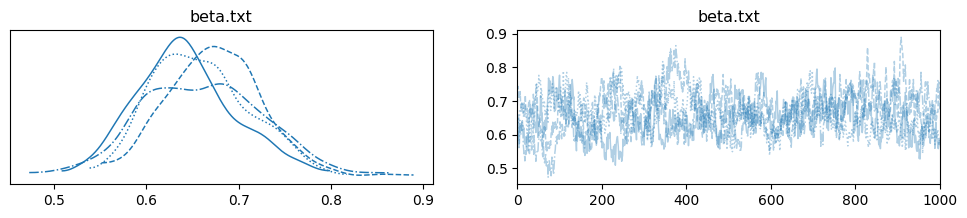

In [4]:
ac.plot_chains_sim(samples, (0,1))

In [11]:
# Check results
res_reduced = ac.reduce_results(samples, (1,101))
inside = [ac.check_inside(0.6, res_reduced[k]["hdi"]) for k in range(1,101)]
means = [res_reduced[k]["mean"] for k in range(1,101)]

print(f"Overalll mean: {np.array(means).mean()}")
print(f"Valids: {np.array(inside).mean()}")
print(f"Rhats: {np.sort(np.concatenate([x.to_array().to_numpy() for x in ac.calc_rhat(samples, (1,101), simplify=True)]))}")

KeyError: 2

### Lambda

In [7]:
l1 = ac.load_traces_parameter("lambda1.txt", "../results/simulation_study/b6-10/")
l2 = ac.load_traces_parameter("lambda2.txt", "../results/simulation_study/b6-10/")
l3 = ac.load_traces_parameter("lambda3.txt", "../results/simulation_study/b6-10/")
l4 = ac.load_traces_parameter("lambda4.txt", "../results/simulation_study/b6-10/")

print(f"Rhats lambda1: {np.concatenate([x.to_array().to_numpy() for x in ac.calc_rhat(l1, (1,101), simplify=True)])}")
print(f"Rhats lambda2: {np.concatenate([x.to_array().to_numpy() for x in ac.calc_rhat(l2, (1,101), simplify=True)])}")
print(f"Rhats lambda3: {np.concatenate([x.to_array().to_numpy() for x in ac.calc_rhat(l3, (1,101), simplify=True)])}")
print(f"Rhats lambda4: {np.concatenate([x.to_array().to_numpy() for x in ac.calc_rhat(l4, (1,101), simplify=True)])}")

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48

In [8]:
l1_reduced = ac.reduce_results(l1, (1,101))
l2_reduced = ac.reduce_results(l2, (1,101))
l3_reduced = ac.reduce_results(l3, (1,101))
l4_reduced = ac.reduce_results(l4, (1,101))

l1_means = [l1_reduced[k]["mean"] for k in range(1,101)]
l2_means = [l2_reduced[k]["mean"] for k in range(1,101)]
l3_means = [l3_reduced[k]["mean"] for k in range(1,101)]
l4_means = [l4_reduced[k]["mean"] for k in range(1,101)]

print(f"Overalll mean: {np.array(l1_means).mean()}")
print(f"Overalll mean: {np.array(l2_means).mean()}")
print(f"Overalll mean: {np.array(l3_means).mean()}")
print(f"Overalll mean: {np.array(l4_means).mean()}")

Overalll mean: 6.162109547350506e-05
Overalll mean: 0.0012222506688167136
Overalll mean: 0.004633597468629038
Overalll mean: 0.010040703214217852
